## Wondering whether we can decode out block position (figured out vs. not) for correct feedbacks
Ensure:
- dataset is balanced (can do this per session)
- no overlaps
Operation per session: 
- filter perseverating
- find smallest # of corrects in a block, N = # / 2
- get first N, last N trials


In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.pseudo_utils as pseudo_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.behavioral_utils as behavioral_utils
import utils.visualization_utils as visualization_utils
from utils.session_data import SessionData

from models.trainer import Trainer
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression
from models.multinomial_logistic_regressor import NormedDropoutMultinomialLogisticRegressor

from trial_splitters.condition_kfold_block_splitter import ConditionKFoldBlockSplitter

import json

from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)

PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
EVENT = "FeedbackOnset"

import matplotlib.pyplot as plt
import matplotlib

### Visualize results

In [17]:
train = np.load(f"/data/patrick_scratch/pseudo/block_position_cor_fb_train_accs.npy")
test = np.load(f"/data/patrick_scratch/pseudo/block_position_cor_fbt_test_accs.npy")

Text(0, 0.5, 'Decoder Accuracy')

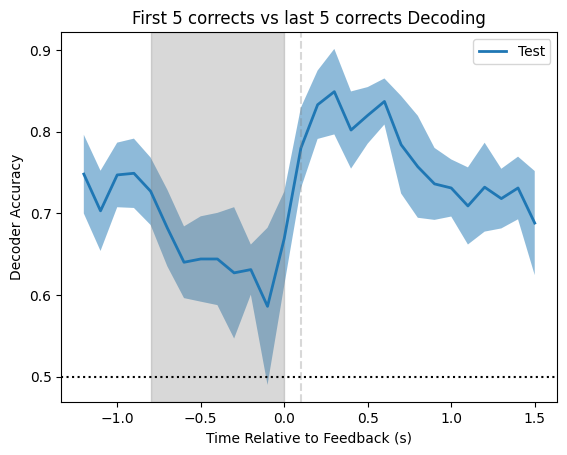

In [15]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test,
    1.3, 1.5, 0.1,
    ax,
    label=f"Test",
    right_align=True, 
)
# visualization_utils.visualize_accuracy_across_time_bins(
#     train,
#     1.3, 1.5, 0.1,
#     ax,
#     label=f"Train",
#     right_align=True, 
# )
ax.legend()
ax.set_title(f"First 5 corrects vs last 5 corrects Decoding")
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### Look at unit 1 from session 20180821 in the ACC, plot:
- Firing rate of correct vs. incorrect
- Firing rate of first 5 correct vs last 5 correct

In [76]:
session = 20180821
unit_id = 0
frs = pd.read_pickle(f"/data/patrick_scratch/multi_sess/{session}/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins.pickle")
behavior_path = f"/data/rawdata/sub-SA/sess-{session}/behavior/sub-SA_sess-{session}_object_features.csv"
beh = pd.read_csv(behavior_path)
valid_beh = behavioral_utils.get_valid_trials(beh)
cor_trials = valid_beh[valid_beh.Response == "Correct"].TrialNumber
inc_trials = valid_beh[valid_beh.Response == "Incorrect"].TrialNumber

unit_frs =  frs[frs.UnitID == unit_id]
cor_frs = unit_frs[unit_frs.TrialNumber.isin(cor_trials)]
inc_frs = unit_frs[unit_frs.TrialNumber.isin(inc_trials)]

def get_fr_np_array(fr_df):
    return fr_df.sort_values(by=["TrialNumber", "TimeBins"])["SpikeCounts"].to_numpy().reshape(len(fr_df.TrialNumber.unique()), len(fr_df.TimeBins.unique()))

cor_vals = get_fr_np_array(cor_frs)
inc_vals = get_fr_np_array(inc_frs)

Text(0, 0.5, 'Spike counts per bin')

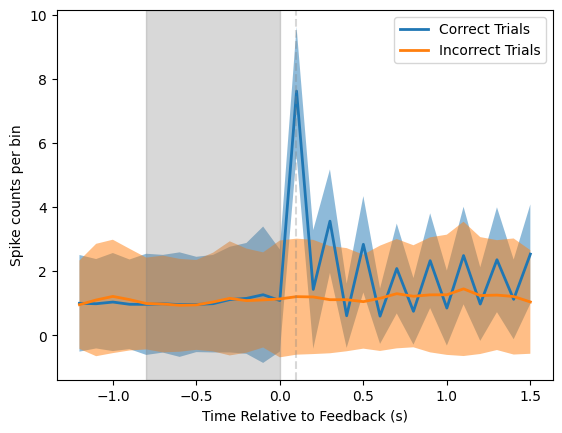

In [77]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    cor_vals.T,
    1.3, 1.5, 0.1,
    ax,
    label=f"Correct Trials",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    inc_vals.T,
    1.3, 1.5, 0.1,
    ax,
    label=f"Incorrect Trials",
    right_align=True, 
)
ax.legend()
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Spike counts per bin")

In [78]:
first_fives = behavioral_utils.get_first_n_corrects_per_block(valid_beh, 5)
last_fives = behavioral_utils.get_last_n_corrects_per_block(valid_beh, 5)

first_five_frs = unit_frs[unit_frs.TrialNumber.isin(first_fives.TrialNumber)]
last_five_frs = unit_frs[unit_frs.TrialNumber.isin(last_fives.TrialNumber)]

first_five_vals = get_fr_np_array(first_five_frs)
last_five_vals = get_fr_np_array(last_five_frs)

Text(0, 0.5, 'Spike counts per bin')

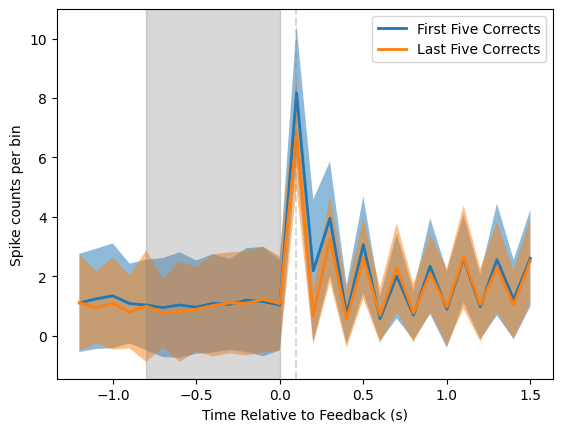

In [79]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    first_five_vals.T,
    1.3, 1.5, 0.1,
    ax,
    label=f"First Five Corrects",
    right_align=True, 
)
visualization_utils.visualize_accuracy_across_time_bins(
    last_five_vals.T,
    1.3, 1.5, 0.1,
    ax,
    label=f"Last Five Corrects",
    right_align=True, 
)
ax.legend()
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Spike counts per bin")